# Generative Adversarial Networks (GANs)

All the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variatonal autoencoders combine neural networks with variationl inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Here's an example of what your outputs from the 3 different models you're going to train should look like... note that GANs are sometimes finicky, so your outputs might not look exactly like this... this is just meant to be a *rough* guideline of the kind of quality you can expect:

![caption](gan_outputs_pytorch.png)

# Model
我们使用 DCGAN 作为 baseline mode。下图为 DCGAN 架构示意图。

![DCGAN](DCGAN.png)

## 初始化操作

In [6]:
import random
import torch
import numpy as np


def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


same_seeds(0)

In [18]:
workspace_dir = os.getcwd()
save_dir = os.path.join(workspace_dir, 'logs')
os.makedirs(save_dir, exist_ok=True)

img_size = 128

# hyperparameters
batch_size = 64
noise_dim = 100
learning_rate = 1e-4
n_epoch = 10

## 准备数据

请将下载好的数据，加压缩到`lab03`的文件目录下, 然后定义我们数据集。这里我们会用 OpenCV 读取图片，由于OpenCV读取的图片模式是BGR，而 Pytorch中的torchvision处理的图片模式是RGB，因此我们需要将BRG转成RGB。

同时为了快速训练一个模型，我们将图片的尺寸resize 到 (64, 64), 当让你也可以修改 img_size 这个参数，调整 resize的尺寸， 不过图片尺寸越大，显存占用也越大，同时训练时间也增多。并且我们让图片的RGB值由 0\~1 线性转换到 -1~1。

In [2]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import glob
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [4]:
class FaceDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    
    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = cv2.imread(fname)
        img = self.BGR2RGB(img) #because "torchvision.utils.save_image" use RGB
        img = self.transform(img)
        return img

    
    def __len__(self):
        return self.num_samples

    
    def BGR2RGB(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [8]:
def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # resize the image to (64, 64)
    # linearly map [0, 1] to [-1, 1]
    transform = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.Resize((64, 64)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3) ] )
    dataset = FaceDataset(fnames, transform)
    return dataset

dataset = get_dataset(os.path.join(workspace_dir, 'faces'))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

### 查看数据集
可以随便选择一张数据集的图片进行查看

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


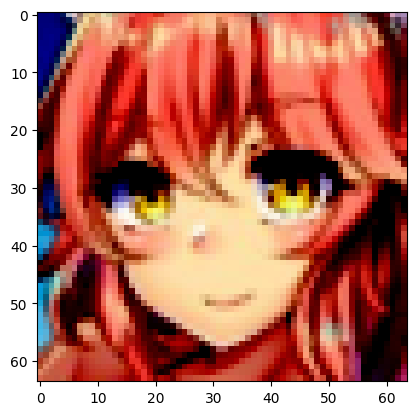

In [9]:
plt.imshow(dataset[10].numpy().transpose(1,2,0))

## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

Hint: use `torch.rand`.

In [11]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    noise = (torch.rand((batch_size, dim)) - 0.5) * 2
    return noise

## CPU / GPU
By default all code will run on CPU. GPUs are not needed for this assignment, but will help you to train your models faster. If you do want to run the code on a GPU, then change the `dtype` variable in the following cell.

In [16]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## 权重初始化

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Discriminator
Our first step is to build a discriminator. Fill in the architecture as part of the `nn.Sequential` constructor in the function below. All fully connected layers should include bias terms. The architecture is:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1
 
Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [21]:
class Discriminator(torch.nn.Module):
    """
    input (N, 3, 128, 128)
    output (N, )
    """
    def __init__(self, in_dim, dim=64):
        super(Discriminator, self).__init__()
        
        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2))
            
        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2), nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2),
            conv_bn_lrelu(dim * 2, dim * 4),
            conv_bn_lrelu(dim * 4, dim * 8),
            nn.Conv2d(dim * 8, 1, 4),
            nn.Sigmoid())
        
        self.apply(weights_init)

    
    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y

# Generator
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024 
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])

In [22]:
class Generator(torch.nn.Module):
    """
    input (N, in_dim)
    output (N, 3, 128, 128)
    """
    def __init__(self, in_dim, dim=64):
        super(Generator, self).__init__()
        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2,
                                   padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU())
            
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 8 * 4 * 4),
            nn.ReLU())
        
        self.l2_5 = nn.Sequential(
            dconv_bn_relu(dim * 8, dim * 4),
            dconv_bn_relu(dim * 4, dim * 2),
            dconv_bn_relu(dim * 2, dim),
            nn.ConvTranspose2d(dim, 3, 5, 2, padding=2, output_padding=1),
            nn.Tanh())
        
        self.apply(weights_init)

    
    def forward(self, x):
        
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y

# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: You should use the `bce_loss` function defined below to compute the binary cross entropy loss which is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$

A naive implementation of this formula can be numerically unstable, so we have provided a numerically stable implementation for you below.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:


`true_labels = torch.ones(size).type(dtype)`

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [ ]:
bce_loss = torch.nn.BCELoss()

def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    N = logits_real.size(0)
    
    labels_real = torch.ones(N).to(device)
    labels_fake = torch.zeros(N).to(device)

    loss_real = None
    loss_fake = None 
    
    loss_real = bce_loss(logits_real, labels_real)
    loss_fake = bce_loss(logits_fake, labels_fake)
    
    loss = loss_real + loss_fake
    return loss
    

def generator_loss(logits_fake, labels_real):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    loss = None
    
    loss = bce_loss(logits_fake, labels_real)
    
    return loss

## Optimizing our loss
Make a function that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. You'll use this to construct optimizers for the generators and discriminators for the rest of the notebook.

In [ ]:
def get_optimizer(model, lr=1e-3, beta1 = 0.5, beta2 = 0.999):
    """
    Construct and return an Adam optimizer for the model with default learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, beta2))
    
    return optimizer

In [19]:
# Model 
G = Generator(in_dim=noise_dim).to(device)
D = Discriminator(3).to(device)
G.train()
D.train()

# optimizer
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

NameError: name 'Generator' is not defined

# Training a GAN!

We provide you the main training loop... you won't need to change this function, but we encourage you to read through and understand it. 

接下来就可以开始训练了。我们定期储存一些图片，让你观察 Generator 目前的效果。并且定期纪录 checkpoint。

In [ ]:
# for logging
z_sample = Variable(torch.randn(100, z_dim)).cuda()

for e, epoch in enumerate(range(n_epoch)):
    for i, data in enumerate(dataloader):
        imgs = data
        imgs = imgs.cuda()

        bs = imgs.size(0)

        """ Train D """
        z = Variable(torch.randn(bs, z_dim)).cuda()
        r_imgs = Variable(imgs).cuda()
        f_imgs = G(z)

        # label
        r_label = torch.ones((bs)).cuda()
        f_label = torch.zeros((bs)).cuda()

        # dis
        r_logit = D(r_imgs.detach())
        f_logit = D(f_imgs.detach())

        # compute loss
        r_loss = criterion(r_logit, r_label)
        f_loss = criterion(f_logit, f_label)
        loss_D = (r_loss + f_loss) / 2

        # update model
        D.zero_grad()
        loss_D.backward()
        opt_D.step()

        """ train G """
        # leaf
        z = Variable(torch.randn(bs, z_dim)).cuda()
        f_imgs = G(z)

        # dis
        f_logit = D(f_imgs)

        # compute loss
        loss_G = criterion(f_logit, r_label)

        # update model
        G.zero_grad()
        loss_G.backward()
        opt_G.step()

        # log
        print(f'\rEpoch [{epoch+1}/{n_epoch}] {i+1}/{len(dataloader)} Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}', end='')
    G.eval()
    f_imgs_sample = (G(z_sample).data + 1) / 2.0
    filename = os.path.join(save_dir, f'Epoch_{epoch+1:03d}.jpg')
    torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
    print(f' | Save some samples to {filename}.')
    # show generated image
    grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
    G.train()
    if (e+1) % 5 == 0:
        torch.save(G.state_dict(), os.path.join(workspace_dir, f'dcgan_g.pth'))
        torch.save(D.state_dict(), os.path.join(workspace_dir, f'dcgan_d.pth'))


# Inference
利用我们训练好的 Generator 来随机生成图片。

In [ ]:
import torch
# load pretrained model
G = Generator(noise_dim)
G.load_state_dict(torch.load(os.path.join(workspace_dir, 'dcgan_g.pth')))
G.eval()
G.to(device)

In [ ]:
# generate images and save the result
n_output = 100
z_sample = Variable(torch.randn(n_output, z_dim)).to(device)
imgs_sample = (G(z_sample).data + 1) / 2.0
save_dir = os.path.join(workspace_dir, 'logs')
filename = os.path.join(save_dir, f'result.jpg')
torchvision.utils.save_image(imgs_sample, filename, nrow=10)
# show image
grid_img = torchvision.utils.make_grid(imgs_sample.cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()